In [1]:
import numpy as np
from umap import UMAP

from sklearn.decomposition import PCA, NMF

from torch import no_grad, flatten
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from efficientnet_pytorch import EfficientNet

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [2]:
path_to_image_folder = '/Users/adamevans/art/datasets/bonsai-warmup'
# note there is a folder within this one with the jpg files
batch_size = 128

In [3]:
# https://github.com/lukemelas/EfficientNet-PyTorch
model = EfficientNet.from_pretrained('efficientnet-b0', )

Loaded pretrained weights for efficientnet-b0


In [4]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Custom dataset that includes image file paths"""

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path


In [5]:
def getImage(path, zoom):
    return OffsetImage(plt.imread(path), zoom=zoom)

In [6]:
def plot_thumbs(embed, all_processed_image_paths, canvas_size=28, zoom=0.05):
    '''Plot thumbnails at projected points in latent space'''
    
    assert X_features.shape[0] == len(all_processed_image_paths)
    
    fig, ax = plt.subplots(figsize=(canvas_size, canvas_size/1.618))
    ax.scatter(embed[:,0], embed[:,1]) 
    
    for x0, y0, path in zip(embed[:,0], embed[:,1], all_processed_image_paths):
        ab = AnnotationBbox(getImage(path, zoom), (x0, y0), frameon=False)
        ax.add_artist(ab)
    plt.show()

In [7]:
# imagenet preprocessing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
# extension of ImageFolder
# from https://gist.github.com/andrewjong/6b02ff237533b3b2c554701fb53d5c4d
dataset = ImageFolderWithPaths(path_to_image_folder,
    transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ]))

In [8]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True
)

In [9]:
all_processed_image_paths, all_features, all_images = [], [], []

# iterate through batches and transform image into feature vector
with no_grad():
    for i, (images, target, paths) in enumerate(train_loader):
        if i == 0: print('Converting images to features...')
        
        # run efficientnet over the images
        # https://github.com/lukemelas/EfficientNet-PyTorch#example-feature-extraction
        features = model.extract_features(images)
        
        flat_images = flatten(images, start_dim=1).detach().numpy()
        flat_features = flatten(features, start_dim=1).detach().numpy()
        
        all_images.append(flat_images)        
        all_features.append(flat_features)
        all_processed_image_paths.extend(paths)
        print(f'Featurized batch #{i} - {min(((i+1)*batch_size) / len(dataset),1.0)}')

X_pixels = np.concatenate(all_images)
X_features = np.concatenate(all_features)

Converting images to features...
Featurized batch #0 - 0.11531531531531532
Featurized batch #1 - 0.23063063063063063
Featurized batch #2 - 0.34594594594594597
Featurized batch #3 - 0.46126126126126127
Featurized batch #4 - 0.5765765765765766
Featurized batch #5 - 0.6918918918918919
Featurized batch #6 - 0.8072072072072072
Featurized batch #7 - 0.9225225225225225
Featurized batch #8 - 1.0


In [10]:
X_pixels.shape

(1110, 150528)

In [11]:
X_features.shape

(1110, 62720)

In [12]:
# reduce raw channels X pixels to 2 dimensions with PCA
pca = PCA(n_components=2)
embed = pca.fit_transform(X_pixels)

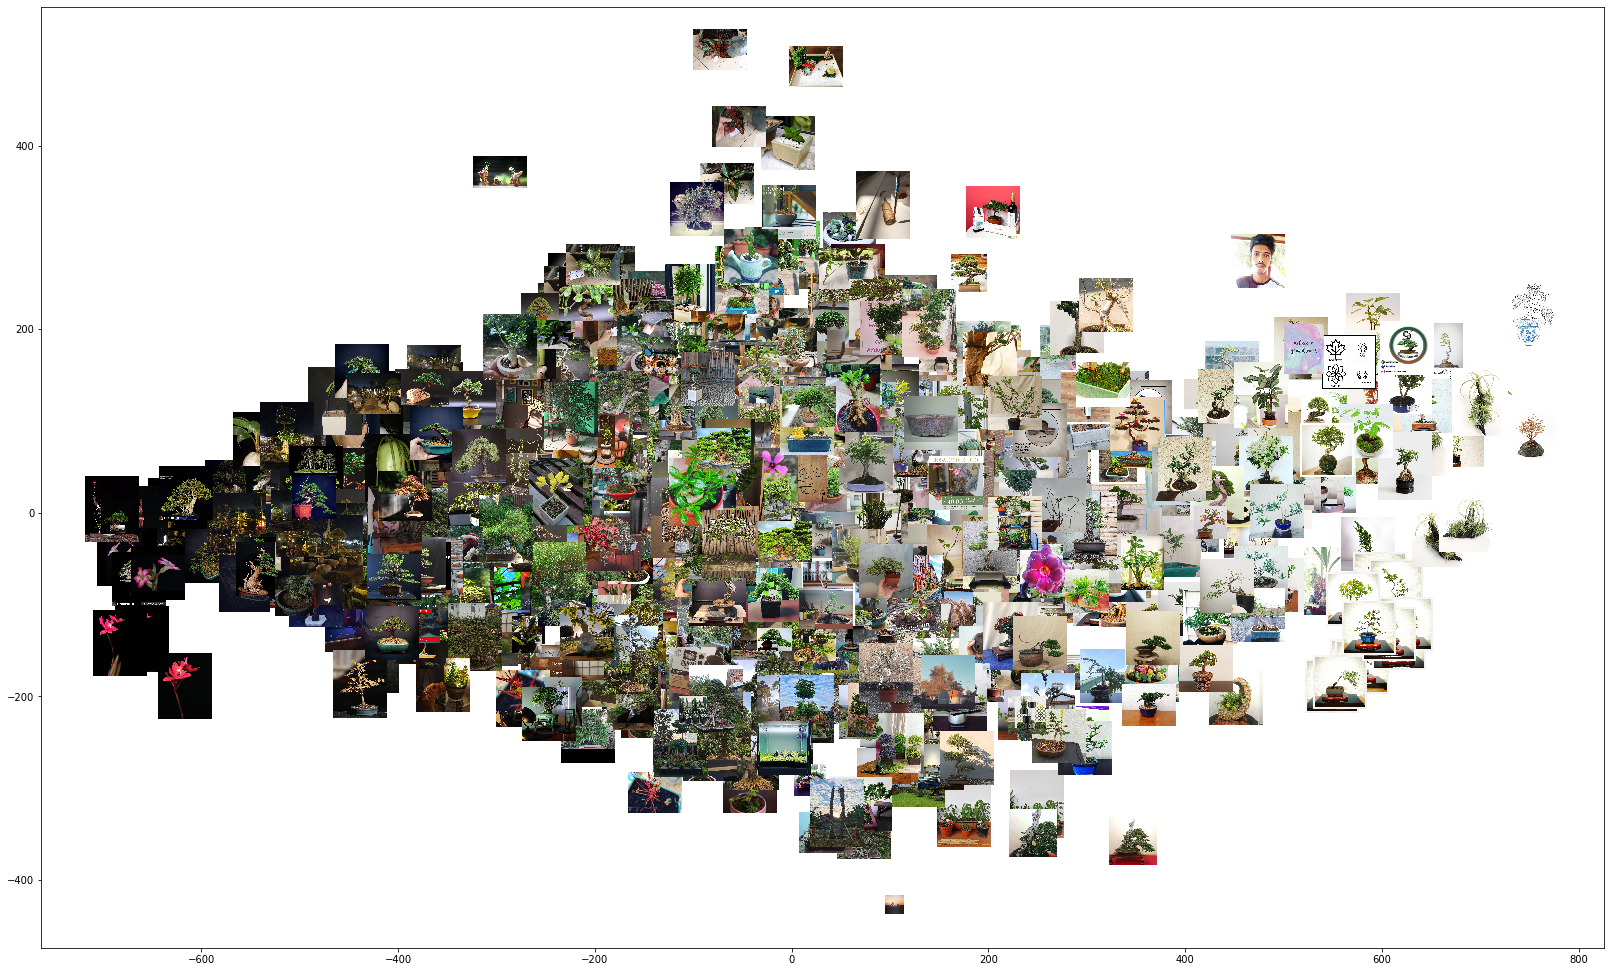

In [14]:
# lovely dark --> light embedding
plot_thumbs(embed, all_processed_image_paths)

In [18]:
# reduce raw channels X pixels to 2 dimensions with UMAP
umap = UMAP(n_components=2)
embed = umap.fit_transform(X_pixels)

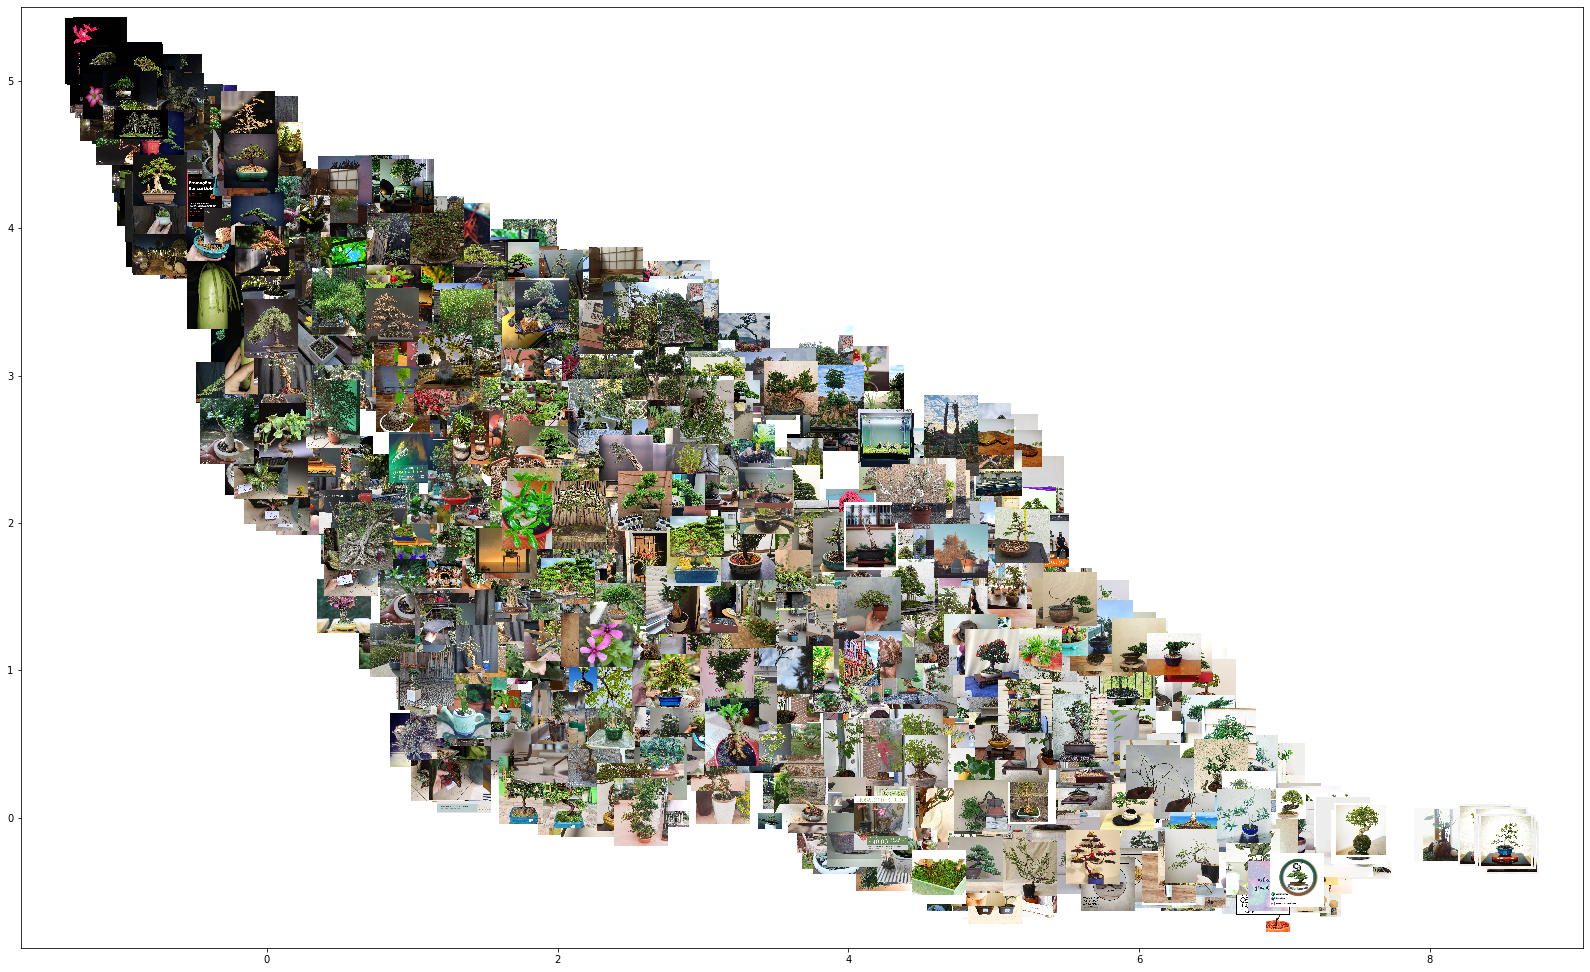

In [19]:
# more.. compact? dark --> light embedding
plot_thumbs(embed, all_processed_image_paths)

In [20]:
# reduce features from efficientnet to 2 dimensions with PCA
pca = PCA(n_components=2)
embed = pca.fit_transform(X_features)

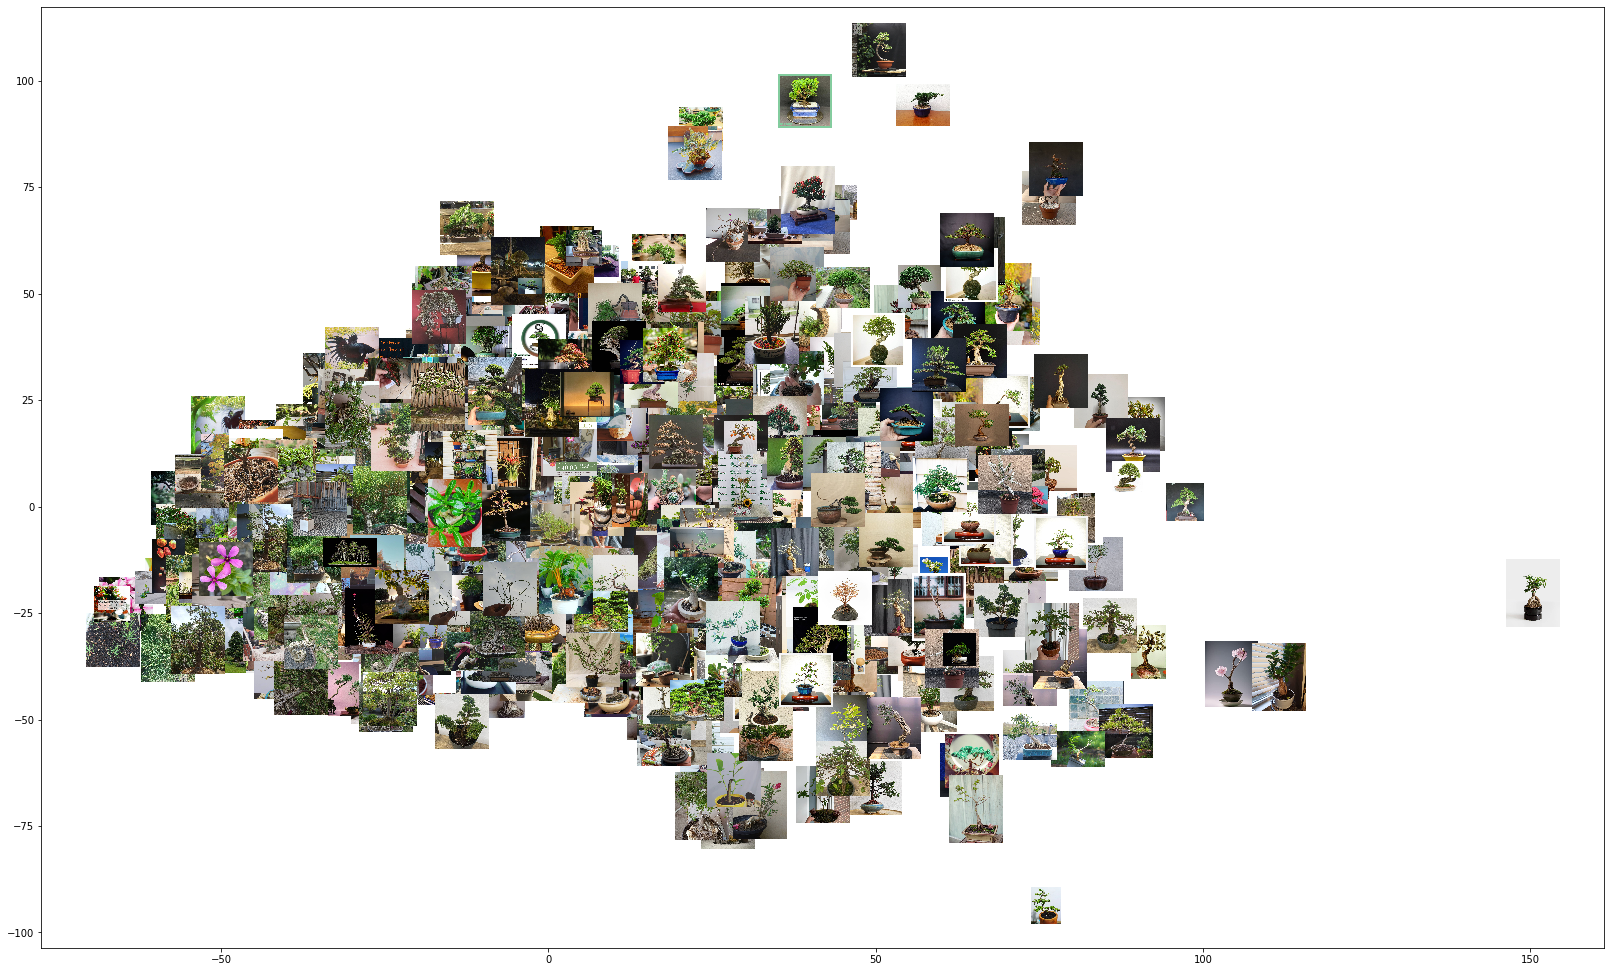

In [21]:
# seems to pick up a more triangular pattern
# direction is much easier to interpret
#   --> goes from busy image / bushy to the left and clean / isolated to the right
plot_thumbs(embed, all_processed_image_paths)

In [22]:
# reduce features from efficientnet to 2 dimensions with UMAP
umap_2 = UMAP(n_components=2)
embed = umap_2.fit_transform(X_features)

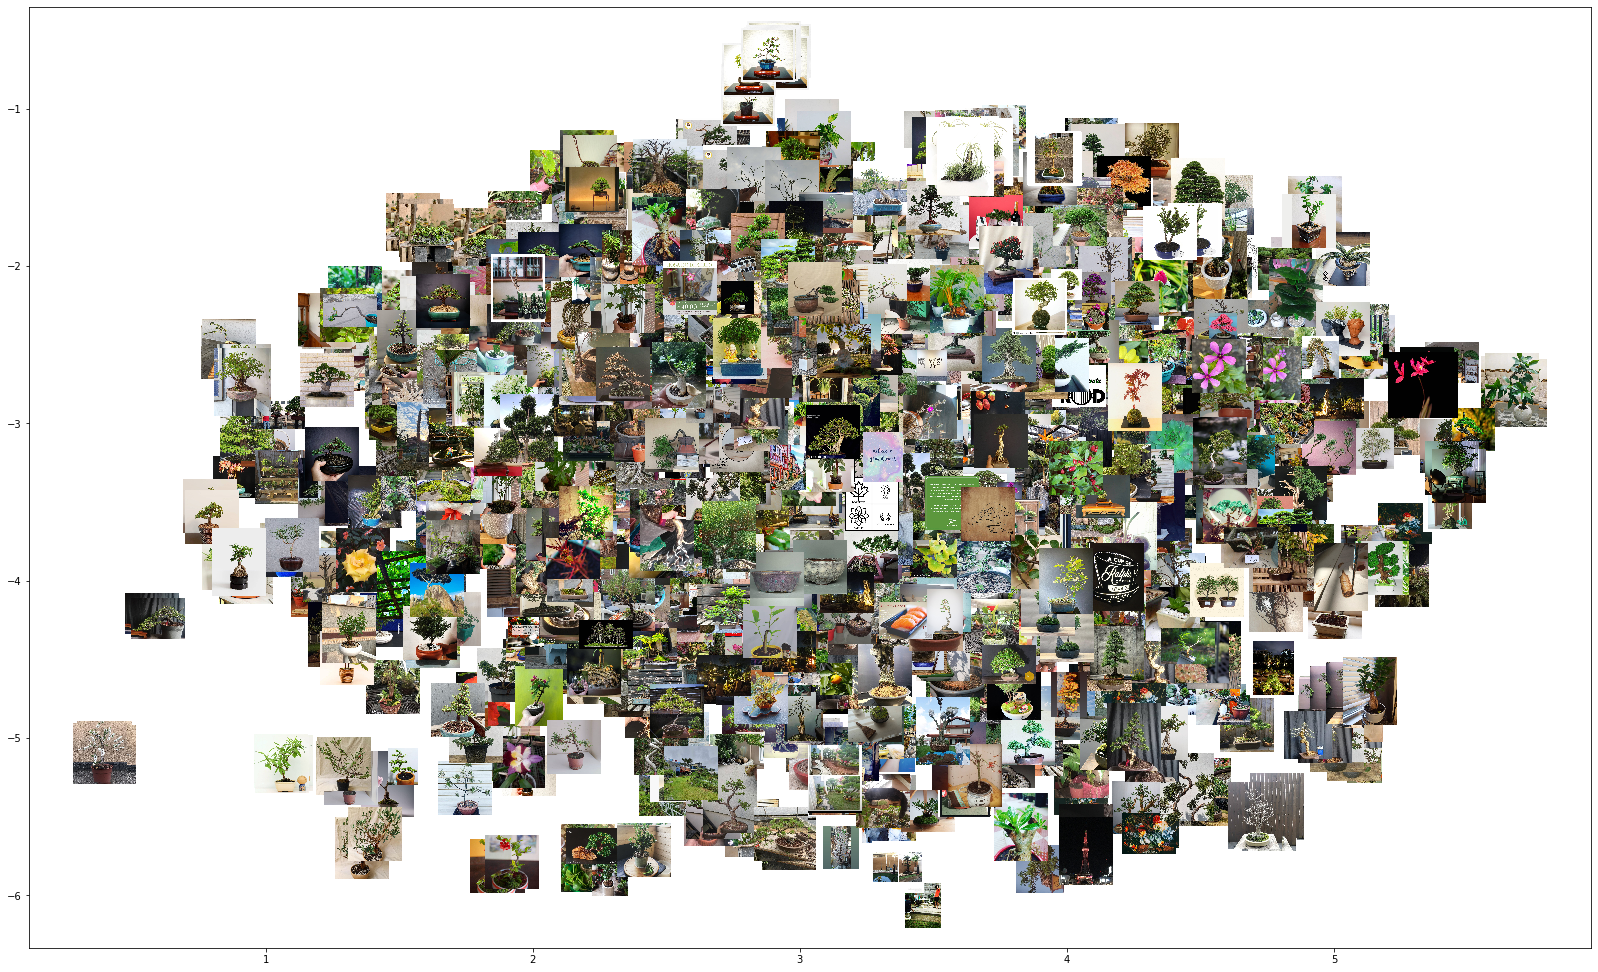

In [23]:
# some kind of embedding.. seems to pick up on same-scene "duplicates" nicely
plot_thumbs(embed, all_processed_image_paths)